In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout

###### predict date range ######
# pd.date_range(start="2021-12-26",end="2022-01-01")
# pd.date_range(start="2022-01-23",end="2022-01-29")

In [2]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [3]:
f1 = pd.read_csv('./Data/ground_temp_train.csv')
f2 = pd.read_csv('./Data/sunrise_sunset_train.csv')

In [4]:
f1['년도'] = pd.to_datetime(f1['일시']).apply(lambda x: x.year)
f1['월'] = pd.to_datetime(f1['일시']).apply(lambda x: x.month)
f1['일'] = pd.to_datetime(f1['일시']).apply(lambda x: x.day)
f1['시'] = pd.to_datetime(f1['일시']).apply(lambda x: x.hour)

f1.drop(columns=['일시'],inplace=True)

In [5]:
f2['Unnamed: 0'] = f2['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
f2['년도'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.year)
f2['월'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.month)
f2['일'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.day)

f2.drop(columns=['Unnamed: 0'],inplace=True)

In [6]:
df0 = pd.read_csv('./Data/smart_farm_train.csv')

test_idx = df0[df0['년월일'] < '2022-02-01'].shape[0]

df0['열공급량(kWh)'] = df0['열공급량(kWh)'] * 1000

# f1 merge
df0 = pd.merge(df0,f1, on=['년도','월','일','시'], how='left')
# f2 merge
df0 = pd.merge(df0,f2, on=['년도','월','일'], how='left')

df0.set_index('시간',inplace=True)
df0.drop(columns=['년월일', '년도', '월', '일', '시', '분'],inplace=True)
df0.head()

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),지면온도(°C),sunrise,sunset
시간,,,,,,,,,,,,,,,,,,,,,
2021-11-26 0:00,-2.7,5.8,67,0.0,325,18.3,62.0,0,0,0,0,0,0,1,0.0,28.0,18.0,900.0,2.7,713,1717
2021-11-26 0:01,-2.9,5.8,67,0.4,344,18.1,63.4,0,0,0,0,0,0,1,0.0,28.0,18.0,900.0,2.7,713,1717
2021-11-26 0:02,-3.0,5.7,67,0.9,105,17.7,65.2,0,0,0,0,0,0,1,1.0,28.0,18.0,900.0,2.7,713,1717
2021-11-26 0:03,-3.0,5.7,67,1.3,123,17.7,63.9,0,0,0,0,0,0,1,1.0,28.0,18.0,800.0,2.7,713,1717
2021-11-26 0:04,-2.8,5.7,67,0.9,123,17.6,64.7,0,0,0,0,0,0,1,1.0,28.0,18.0,1000.0,2.7,713,1717


In [7]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df0[df0.columns.difference(['열공급량(kWh)'])]) 
Y_data = Y_scaler.fit_transform(df0[['열공급량(kWh)']])

In [8]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

# row : min -> 분단위 예측~
hist_window = 60
horizon = 10
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, test_idx, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, test_idx, None, hist_window, horizon) 


In [14]:
print("before train x data shape:",X_data.shape)
print("before train y data shape:",Y_data.shape)

before train x data shape: (130886, 20)
before train y data shape: (130886, 1)


In [13]:
print("transformed train x data shape:",x_train.shape) # (data length, hist_window, n_features)
print("transformed train y data shape:",y_train.shape) # (data length, horizon, n_features)

transformed train x data shape: (91312, 60, 20)
transformed train y data shape: (91312, 10, 1)


In [9]:
batch_size = 64
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [10]:
lstm_model = tf.keras.models.Sequential([
    LSTM(200, return_sequences=True, input_shape=x_train.shape[-2:]),
    Dense(128, activation='tanh'),
    LSTM(200),
    Dropout(0.5),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dropout(0.5),
    Dense(units=horizon),
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 200)           176800    
                                                                 
 dense (Dense)               (None, 60, 128)           25728     
                                                                 
 lstm_1 (LSTM)               (None, 200)               263200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               25728     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [11]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', min_delta=0, patience=25, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_rmse', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=20,verbose=1,callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 8s 67ms/step - loss: 0.0421 - rmse: 0.2051 - val_loss: 0.0102 - val_rmse: 0.1012
Epoch 2/100
100/100 [==============================] - 6s 63ms/step - loss: 0.0201 - rmse: 0.1419 - val_loss: 0.0089 - val_rmse: 0.0945
Epoch 3/100
100/100 [==============================] - 6s 62ms/step - loss: 0.0140 - rmse: 0.1185 - val_loss: 0.0096 - val_rmse: 0.0977
Epoch 4/100
100/100 [==============================] - 6s 62ms/step - loss: 0.0086 - rmse: 0.0929 - val_loss: 0.0093 - val_rmse: 0.0963
Epoch 5/100
100/100 [==============================] - 6s 62ms/step - loss: 0.0119 - rmse: 0.1090 - val_loss: 0.0086 - val_rmse: 0.0927
Epoch 6/100
100/100 [==============================] - 6s 62ms/step - loss: 0.0087 - rmse: 0.0935 - val_loss: 0.0093 - val_rmse: 0.0963
Epoch 7/100
100/100 [==============================] - 6s 62ms/step - loss: 0.0077 - rmse: 0.0880 - val_loss: 0.0101 - val_rmse: 0.1004
Epoch 8/100
100/100 [===========================

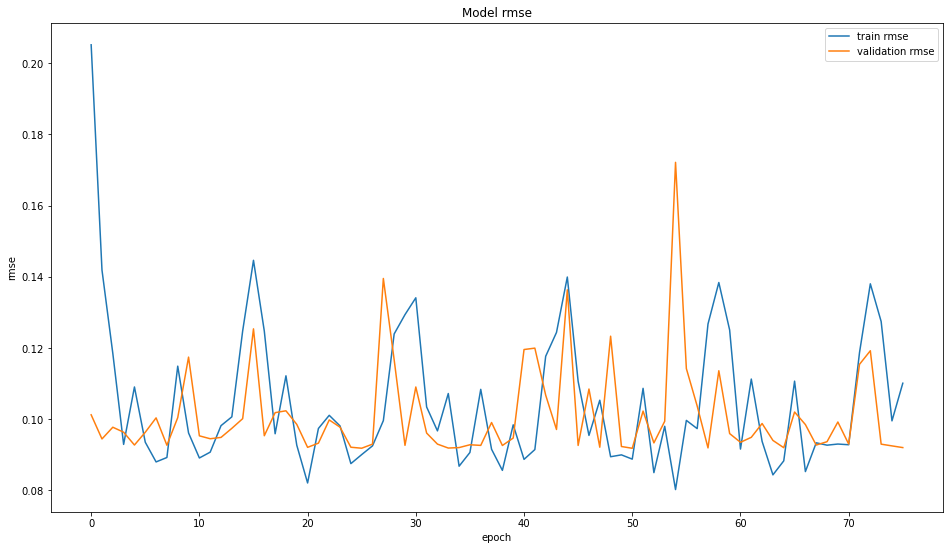

In [12]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

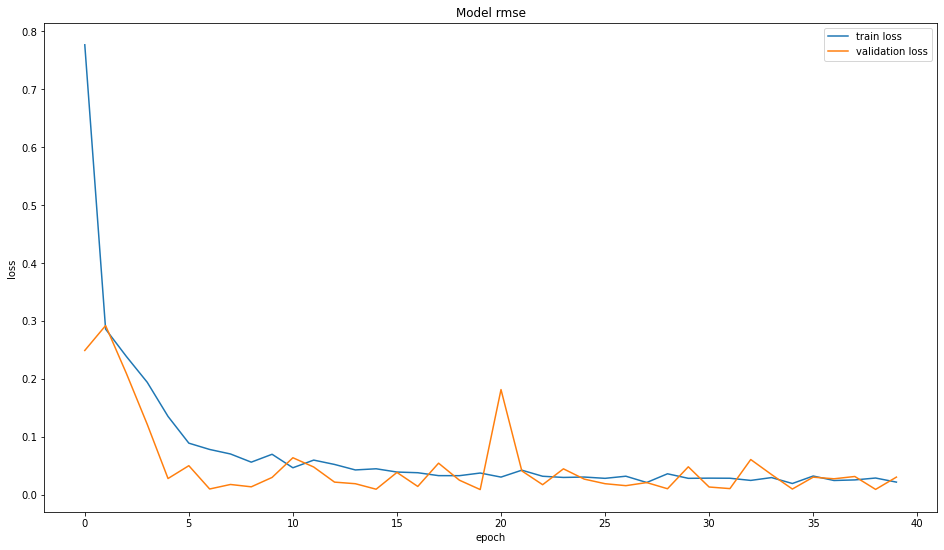

In [33]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model rmse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()